In [44]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import sys
import string
import logging
import tempfile
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import ticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import inset_locator
import matplotlib.font_manager as fm

import superscreen as sc

plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["font.size"] = 18

SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(os.path.join(os.pardir, "images"), exist_ok=True)
    
sys.path.insert(0, "/Users/LoganBVH/GitHub/superscreen-squids")
import squids

In [45]:
sc.version_table()

Software,Version
SuperScreen,0.1.1
Numpy,1.20.3
SciPy,1.6.3
matplotlib,3.4.3
ray,1.4.1
IPython,7.24.1
Python,"3.9.5 (default, May 18 2021, 12:31:01) [Clang 10.0.0 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 2, Logical: 4"
BLAS Info,OPENBLAS


## Spatially inhomogeneous $\Lambda$

### Define the `Device` geometry

In [46]:
import superscreen as sc
from superscreen.geometry import circle, box

length_units = "um"
ro = 3  # outer radius
ri = 1  # inner radius
slit_width = 0.25
layer = sc.Layer("base", Lambda=1.0, z0=0)

ring = circle(ro)
hole = circle(ri)
slit = box(slit_width, 1.5 * (ro - ri), center=(0, -(ro + ri) / 2))

film = sc.Polygon.from_difference([ring, slit, hole], name="ring_with_slit", layer="base")
# # The above is equivalent to all of the following:
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit, hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(slit).difference(hole)
# film = sc.Polygon(
#     name="ring_with_slit", layer="base", points=ring
# ).difference(sc.Polygon(points=hole).union(slit))

film = film.resample(500)
bounding_box = sc.Polygon("bounding_box", layer="base", points=circle(1.2 * ro))

device = sc.Device(
    film.name,
    layers=[layer],
    films=[film],
    abstract_regions=[bounding_box],
    length_units=length_units,
)

### Define a `Parameter` to compute $\Lambda(x, y)$

In [51]:
def linear_vs_angle(
    x: np.ndarray, y: np.ndarray, *, min_val: float, max_val: float
) -> np.ndarray:
    # Rotate the input coordinates so that theta = 0
    # corresponds to the slit position (along the -y axis).
    x, y = sc.geometry.rotate(
        np.stack(np.atleast_1d(x, y), axis=1), np.degrees(-np.pi / 2)
    ).T
    # Calculate the angular position of each mesh vertex.
    angles = np.arctan2(y, x) + np.pi  # range: [0, 2 * pi]
    # Set Lambda to increase linearly from min_val to max_val
    # as a function of angular position.
    Lambdas = angles / (2 * np.pi) * (max_val- min_val) + min_val
    return Lambdas

Lambda = sc.Parameter(linear_vs_angle, min_val=0.1, max_val=1.0)
print(Lambda)

Parameter<linear_vs_angle(min_val=0.1, max_val=1.0)>


### Solve the model

In [53]:
# Assign the Parameter Lambda as the penetration depth of the superconducting layer.
device.layers["base"].Lambda = Lambda
# Generate the mesh and solve.
device.make_mesh(min_triangles=7000, optimesh_steps=None)
solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(10),
    field_units="uT",
)[-1]

INFO:superscreen.device.device:Generating mesh...
INFO:superscreen.device.device:Finished generating mesh with 3611 points and 7108 triangles.
INFO:superscreen.device.device:Calculating weight matrix.
INFO:superscreen.device.device:Calculating Laplace operator.
INFO:superscreen.device.device:Calculating kernel matrix.
INFO:superscreen.solve:Calculating base response to applied field.


### Visualize the results

In [54]:
# Sub-figure for Lambda(x, y)
fig_L, ax_L = plt.subplots(figsize=(5, 4))
ax_L.set_aspect("equal")
x, y = device.points.T
triangles = device.triangles
min_Lambda = Lambda.kwargs["min_val"]
max_Lambda = Lambda.kwargs["max_val"]
levels = np.linspace(min_Lambda, max_Lambda, 201)
im = ax_L.tricontourf(x, y, triangles, Lambda(x, y), levels=levels, cmap="bone")
device.films["ring_with_slit"].plot(ax=ax_L, color="C1", lw=3)
cbar = fig_L.colorbar(im, ax=ax_L)
cbar.set_ticks([min_Lambda, max_Lambda])
cbar.set_label("$\\Lambda(x, y)$ [$\\mu$m]", labelpad=-16)
ax_L.axis("off")
scale = 2
um = "$\\mu$m"
scalebar = AnchoredSizeBar(
    transform=ax_L.transData,
    size=scale,
    size_vertical=scale/10,
    loc="lower right",
    label=f"{scale} {um}",
    color="k",
    frameon=False,
    label_top=True,
    pad=-0.5,
    fontproperties=fm.FontProperties(size=20),
)
ax_L.add_artist(scalebar)

# Sub-figure for current density
fig_j, (ax_j, ) = solution.plot_currents(figsize=(5, 4))
ax_j.axis("off")
ax_j.set_title("")

# Sub-figure for magnetic field at z = 0 um
fig_h, (ax_h, ) = solution.plot_fields(figsize=(5, 4))
ax_h.axis("off")
ax_h.set_title("")

# Sub-figure for magnetic field at z = 0.5 um
fig_hf, (ax_hf, ) = solution.plot_field_at_positions(device.points, zs=0.5, figsize=(5, 4))
ax_hf.axis("off")
ax_hf.set_title("")

# Save sub-figures to a temporary directory and load them as images.
with tempfile.TemporaryDirectory() as path:
    fig_L.savefig(os.path.join(path, "Lambda.png"), dpi=600, bbox_inches="tight")
    fig_h.savefig(os.path.join(path, "fields.png"), dpi=600, bbox_inches="tight")
    fig_j.savefig(os.path.join(path, "currents.png"), dpi=600, bbox_inches="tight")
    fig_hf.savefig(os.path.join(path, "fields_at_position.png"), dpi=600, bbox_inches="tight")
    im_L = plt.imread(os.path.join(path, "Lambda.png"))
    im_h = plt.imread(os.path.join(path, "fields.png"))
    im_j = plt.imread(os.path.join(path, "currents.png"))
    im_hf = plt.imread(os.path.join(path, "fields_at_position.png"))

plt.close(fig_L)
plt.close(fig_h)
plt.close(fig_j)
plt.close(fig_hf)

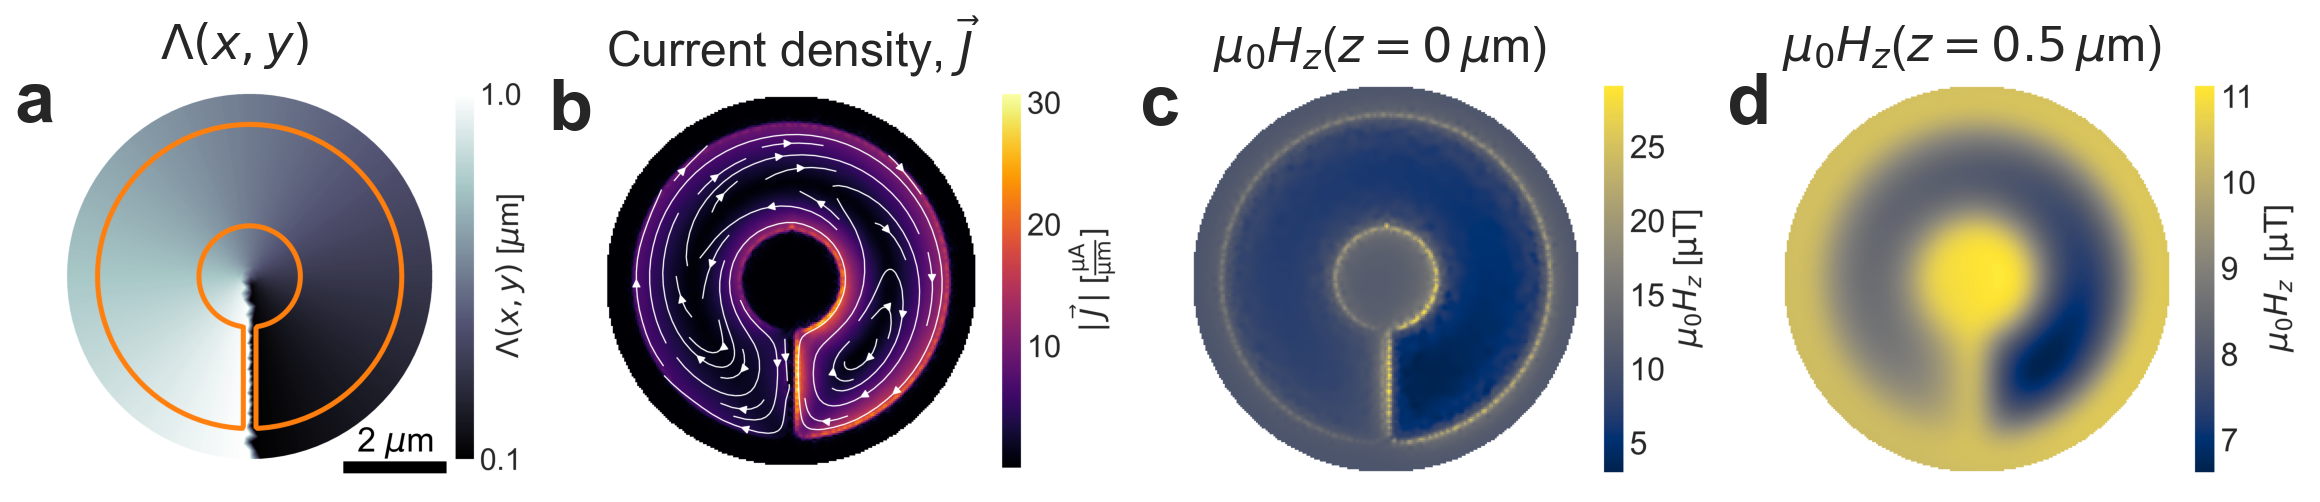

In [55]:
# Populate the full figure with sub-figures
fig, axes = plt.subplots(
    1, 4,
    figsize=(16, 4),
    facecolor="w",
    constrained_layout=True,
    gridspec_kw=dict(width_ratios=[0.9, 1, 1, 1])
)
    
axes[0].imshow(im_L)
axes[1].imshow(im_j)
axes[2].imshow(im_h)
axes[3].imshow(im_hf)

labels = [
    "$\\Lambda(x, y)$",
    "Current density, $\\vec{J}$",
    "$\\mu_0H_z$($z=0\\,\\mu$m)",
    "$\\mu_0H_z$($z=0.5\\,\\mu$m)",
]

for ax, label, title in zip(axes.flat, string.ascii_lowercase, labels):
    ax.set_aspect("equal")
    ax.grid(False)
    ax.axis("off")
    ax.set_title(title, x=0.5 - 0.125, fontsize=24)
    ax.text(0, 1, label, weight="bold", size=36, transform=ax.transAxes, ha="right", va="top")
        
if SAVE_FIGURES:
    fig.savefig("../images/ring_with_slit_inhomogeneous.pdf", bbox_inches="tight")